<a href="https://colab.research.google.com/github/AftabKhalil/Colabs/blob/main/Using_Convolutional_Neural_Networks_for_Facial_Expression_Recognition_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aftab Khalil - 19837
## Using Convolutional Neural Networks for Facial Expression Recognition
<hr/>

<h2><u>Imports</u></h2>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import cv2
import random
import math
import time
import pandas as pd

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

from ipywidgets import IntProgress
from IPython.display import display

<h2><u>Initializations of global variables</u></h2>

In [ ]:
img_height = 48          # The desired height of images
img_width  = 48          # The desired width of images
epoches    = 50          # No of epochs in training process
num_classes = 0          # No of classes in dataset, Will be initialized later below
momentum   = 0.1         # It is the momentum used in SGD approach and will be set as per the approach in below code

<h2><u>Dataset</u></h2>
<p>The dataset is taken from one of Kaggle free dataset repos: <a href="https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset">Face expression recognition dataset</a> It has images for 7 basic emotions (listed above) and training and testing datsets are seperated.<p>

In [ ]:
training_data_dir = pathlib.Path('./data/train/')        # 'data/train' is the folder with training dataset
training_images_count = len(list(training_data_dir.glob('*/*.jpg'))) 
print(f"There are a total of {training_images_count} images in training dataset.")

testing_data_dir = pathlib.Path('./data/validation/') # 'data/validation' is the folder with validation dataset
testing_images_count = len(list(testing_data_dir.glob('*/*.jpg')))
print(f"There are a total of {testing_images_count} images in validation dataset.")

There are a total of 28821 images in training dataset.
There are a total of 7066 images in validation dataset.


<h2><u>Read dataset function</u></h2>
<br/>
(Reference : <a href="https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6">https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6</a>)

In [ ]:
#A function defined to read datasst from data folder, It iterates over all sub directories of given root directory
#and read and resize all images in them
#args - root_folder : The root folder of dataset
#return - classes : Classes in dataset
#       - images  : Actuall data
#       - labels  : Labels of data
def create_dataset(root_folder):
    max_count = len(list(root_folder.glob('*/*.jpg')))
    f = IntProgress(min = 0, max = max_count) # instantiate the bar
    display(f) # display the bar

    classes   = {}
    images    = []
    labels_s  = []
    labels_i  = []
    i = 0;
    for dir in os.listdir(root_folder):
        for file in os.listdir(os.path.join(root_folder, dir)):
            image_path = os.path.join(root_folder, dir, file)         #image path
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)          #read color image
            #image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21) #Reduce noise (https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html)
            image = cv2.resize(image, (img_height, img_width))        #resize image
            image = np.array(image)                                   #change image into numpy array
            image = image.astype('float32')                           #set type as float, for future division
            image /= 255.0                                            #diviing by 25 to normalize the pixel to [0,1]
            images.append(image)                                      #add image to imges
            labels_s.append(dir)                                        #add dir name to label, dir name is class label
            labels_i.append(i)
            f.value += 1 # signal to increment the progress bar
        i += 1
        
    unique_labels = np.unique(labels_s)                                 #get unique labels
    for i in range(len(unique_labels)):                               #create dictionary of class label and identifier
        classes[i] = unique_labels[i]
            
    return classes, images, labels_i

<h2><u>Read training dataset</u></h2>

In [ ]:
#read train dataset and get classes, images and labels
classes, training_images, training_labels = create_dataset(training_data_dir)
training_images, training_labels = shuffle(training_images, training_labels)

#set value for num_classes
num_classes = len(classes)

print(f'Classes in dataset are {classes}')

IntProgress(value=0, max=28821)

Classes in dataset are {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


<h2><u>Insights of training dataset</u></h2>

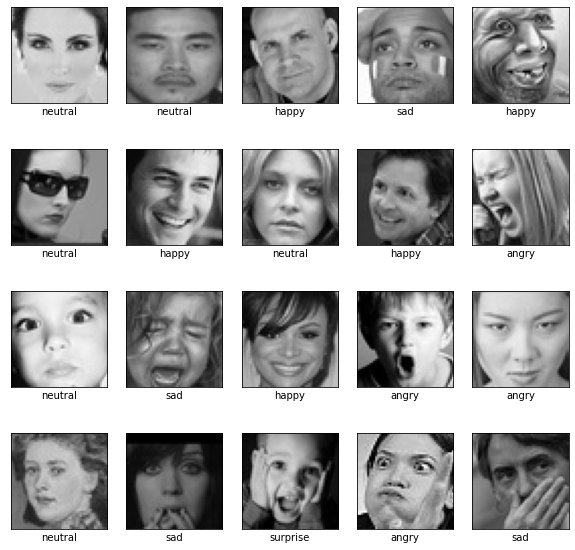

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(training_images[i])
    plt.xlabel(classes[training_labels[i]])
plt.show()

<h2><u>Read testing dataset</u></h2>

In [ ]:
#read test dataset and get classes, images and labels
_, testing_images, testing_labels = create_dataset(testing_data_dir)
testing_images, testing_labels = shuffle(testing_images, testing_labels)

IntProgress(value=0, max=7066)

<h2><u>Insights of testing dataset</u></h2>

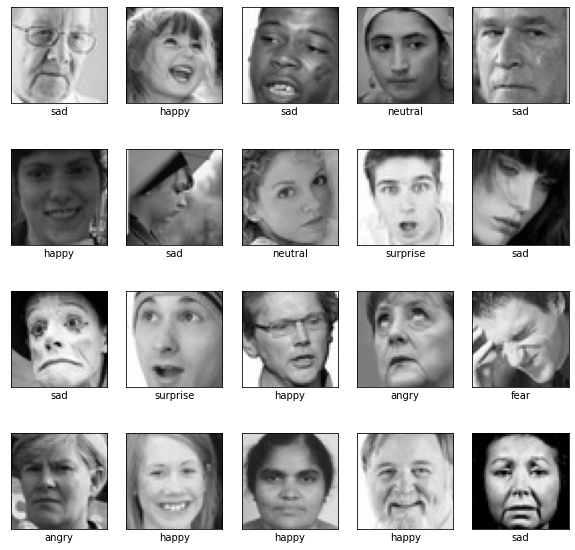

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testing_images[i])
    plt.xlabel(classes[testing_labels[i]])
plt.show()

In [ ]:
#change list to array for future use
training_images = np.array(training_images)
training_labels = np.array(training_labels)

testing_images = np.array(testing_images)
testing_labels = np.array(testing_labels)

<h2><u>Building model (CNN)</u></h2>
<br/>
Below blocks are referenced from : <a href="https://www.tensorflow.org/tutorials/images/classification">https://www.tensorflow.org/tutorials/images/classification</a>

In [ ]:
#Set the parameters for different Approaches here
#Uncomment the one that should be tested

#A1
#optimizer = "sgd"; momentum = 0.1; dropout = 'none'

#A2
#optimizer = "sgd"; momentum = 0.5; dropout = 'none'

#A3
#optimizer = "sgd"; momentum = 0.9; dropout = 'none'

#A4
#optimizer = "sgd"; momentum = 0.1; dropout = 'min'

#A5
#optimizer = "sgd"; momentum = 0.5; dropout = 'min'

#A6
#optimizer = "sgd"; momentum = 0.9; dropout = 'min'

#A7
#optimizer = "sgd"; momentum = 0.1; dropout = 'max'

#A8
#optimizer = "gsd"; momentum = 0.5; dropout = 'max'

#A9
#optimizer = "sgd"; momentum = 0.9; dropout = 'max'

#A10
#optimizer = "adam"; dropout = 'none'

#A11
optimizer = "adam"; dropout = 'min'

#A12
#optimizer = "adam"; dropout = 'max'

#A13
#optimizer = "adam"; momentum = 0.1; dropout = 'two'

In [ ]:
#Model is sequential, i.e each layer is connected to its pre and post layer only
model = Sequential()

#Input layer
model.add(layers.InputLayer(input_shape=(img_height, img_width, 3)))

#First Convolution and Maxpooling layer
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3) , activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#Second Convolution and Maxpooling layer
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3) , activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#Third Convolution and Maxpooling layer
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),  activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#Add this dropout layer only if its A13 case
if dropout == 'two':
    model.add(layers.Dropout(0.3))

#Forth Convolution and Maxpooling layer    
model.add(layers.Conv2D(filters = 128, kernel_size = (3,3),  activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#Add dropout layer in all cases except if its 'none'
if dropout != 'none':
    model.add(layers.Dropout(0.3))

#Flaten the result so far
model.add(layers.Flatten())

#Normal dense layer with 64 neuron
model.add(layers.Dense(128, activation='relu'))

#Add this droput only if max dropout is selected
if dropout == 'max':
    model.add(layers.Dropout(0.3))
    
#Normal dense layer with 32 neuron
model.add(layers.Dense(32, activation='relu'))

if dropout == 'max':
    model.add(layers.Dropout(0.3))

#Normal dense layer with 16 neuron
model.add(layers.Dense(16, activation='relu'))

if dropout == 'max':
    model.add(layers.Dropout(0.3))

#Normal dense layer with neuron equal to number of classes, i.e its the output layer
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         7

<h2><u>Visualization of model</u></h2>

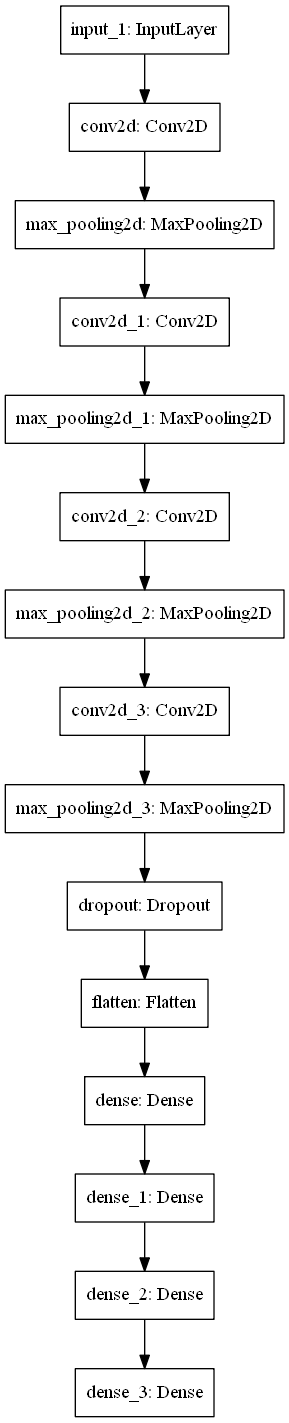

In [ ]:
plot_model(model, to_file = 'model.png')

<h2><u>Compile and run model</u></h2>

In [ ]:
#define sgd optimizer
sgd = tf.keras.optimizers.SGD(
    learning_rate = 0.001, momentum = momentum, nesterov = False, name = "sgd"
)

#Select optimizor
optimizer = 'sgd' if optimizer == 'sgd' else 'adam'

print(f'Optimizer is {optimizer}')

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

start_time = time.time()

#Finally fit the model and train data and test on test data
history = model.fit(
    training_images,
    training_labels,
    epochs = epoches,
    validation_data = (testing_images, testing_labels))

end_time = time.time()

elapsed = end_time - start_time
print("Total time taken is = ", elapsed)

Optimizer is adam
Train on 28821 samples, validate on 7066 samples
Epoch 1/50
28821/28821 [==============================] - 106s 4ms/sample - loss: 1.9010 - accuracy: 0.2440 - val_loss: 1.8899 - val_accuracy: 0.2583
Epoch 2/50
28821/28821 [==============================] - 96s 3ms/sample - loss: 1.8923 - accuracy: 0.2547 - val_loss: 1.8852 - val_accuracy: 0.2642
Epoch 3/50
28821/28821 [==============================] - 99s 3ms/sample - loss: 1.8837 - accuracy: 0.2609 - val_loss: 1.8765 - val_accuracy: 0.2686
Epoch 4/50
28821/28821 [==============================] - 97s 3ms/sample - loss: 1.8151 - accuracy: 0.3313 - val_loss: 1.7802 - val_accuracy: 0.3740
Epoch 5/50
28821/28821 [==============================] - 97s 3ms/sample - loss: 1.7694 - accuracy: 0.3842 - val_loss: 1.7436 - val_accuracy: 0.4086
Epoch 6/50
28821/28821 [==============================] - 98s 3ms/sample - loss: 1.7511 - accuracy: 0.4033 - val_loss: 1.7427 - val_accuracy: 0.4117
Epoch 7/50
28821/28821 [==============

<h2><u>Visualization of results</u></h2>

[0.2582791, 0.26422304, 0.26861024, 0.37404472, 0.40857628, 0.4116898, 0.40801018, 0.42456836, 0.42810643, 0.45174074, 0.45103312, 0.46277952, 0.45683554, 0.4582508, 0.4646193, 0.4776394, 0.48046985, 0.47169545, 0.46858194, 0.46476084, 0.48061138, 0.4794792, 0.47650722, 0.4814605, 0.46985564, 0.48160204, 0.48301727, 0.47523353, 0.48966885, 0.49235776, 0.4906595, 0.48938578, 0.49518824, 0.49320692, 0.49957544, 0.49419758, 0.50056607, 0.49801868, 0.5009907, 0.48499858, 0.48514012, 0.48797056, 0.50042456, 0.5033966, 0.49844325, 0.50481176, 0.50834984, 0.5086329, 0.51245403, 0.51712424]
[1.8899049668146064, 1.8852497967518391, 1.876479278601434, 1.7801725211509254, 1.7436369488133339, 1.7427112347270557, 1.7442733864928655, 1.7301414299375641, 1.721860208627424, 1.7041141483758753, 1.7039441597417837, 1.6934608294273483, 1.6990893115546526, 1.6982188446475195, 1.6922637100028073, 1.6793021147223461, 1.6768837251779278, 1.685376021364678, 1.6889436093801957, 1.6929747638910242, 1.6777376801

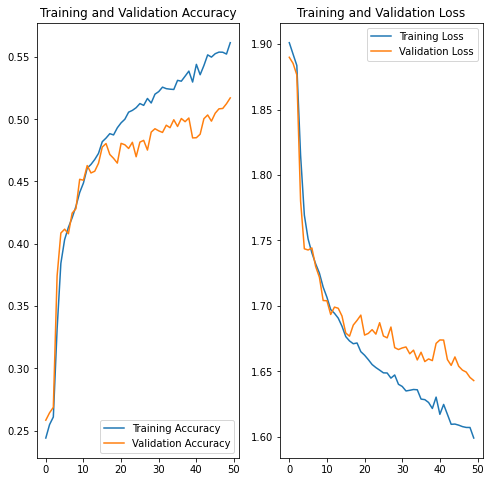

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(val_acc)

loss = history.history['loss']
val_loss = history.history['val_loss']
print(val_loss)

epochs_range = range(epoches)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<hr/>
<hr/>
<h2><u>Prediction of random Images</u></h2>

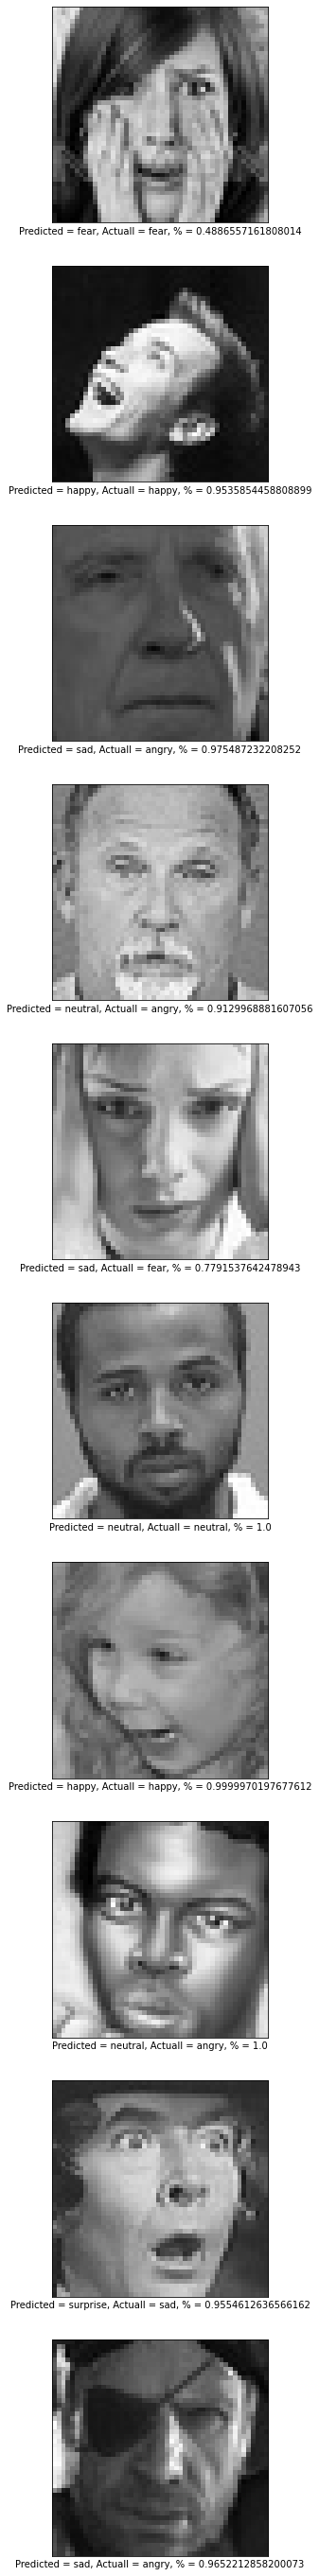

In [ ]:
plt.figure(figsize=(10, 100))
for i in range(10):
    r = random.randint(0, len(testing_images))
    pr  = model.predict(np.expand_dims(testing_images[r], axis=0))[0]
    mpr = np.max(pr)
    p  = np.argmax(pr)
    
    plt.subplot(20, 1 , i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testing_images[r])
    plt.xlabel(f'Predicted = {classes[p]}, Actuall = {classes[testing_labels[r]]}, % = {abs(mpr)}')
plt.show()

<hr>
<h2><u>Class wise accuracy</u></h2>

In [ ]:
class_wise_accuracy = [len(classes)]
for c in classes:
    images_of_class = testing_images[testing_labels == c]
    print(f'images of class {c} = {len(images_of_class)}')
    
    d = {}
    for i in range(len(classes)):
        d[i] = 0    
        
    for image in images_of_class:
        pr = model.predict(np.expand_dims(image, axis = 0))[0]
        p  = np.argmax(pr)
        d[p] = d[p] + 1
        
    print(d)
    class_wise_accuracy.append(d)

images of class 0 = 960
{0: 242, 1: 0, 2: 119, 3: 125, 4: 197, 5: 257, 6: 20}
images of class 1 = 111
{0: 26, 1: 0, 2: 17, 3: 18, 4: 15, 5: 31, 6: 4}
images of class 2 = 1018
{0: 108, 1: 0, 2: 284, 3: 131, 4: 160, 5: 237, 6: 98}
images of class 3 = 1825
{0: 86, 1: 0, 2: 67, 3: 1431, 4: 92, 5: 134, 6: 15}
images of class 4 = 1216
{0: 52, 1: 0, 2: 76, 3: 163, 4: 673, 5: 235, 6: 17}
images of class 5 = 1139
{0: 91, 1: 0, 2: 128, 3: 114, 4: 243, 5: 553, 6: 10}
images of class 6 = 797
{0: 23, 1: 0, 2: 120, 3: 92, 4: 55, 5: 36, 6: 471}


<hr>
<h1>END 🐍</h1> 